# Project Part 3

## Project Goal and Significance

### Goal

The objective of Part 3 of this project is to **predict** a specific customer's product rating by leveraging **user intrinsic characteristics** (e.g., skin tone, skin type, hair color, total negative feedback count, total positive feedback count, etc.) and **product features** (e.g., product name, loves count, average rating, etc.). We also plan to analyze which features contribute most to product ratings, providing meaningful insights into customer preferences and product considerations.

### Significance
This project holds value in several key areas:
1. **Personalized Recommendations**: Enables tailored product suggestions by leveraging customer and product attributes, enhancing user experience.
2. **Improved Customer Satisfaction**: Delivers actionable insights to meet individual preferences more effectively.
3. **Business Insights**: Helps businesses identify features that drive satisfaction, informing product improvements and marketing strategies.
4. **Advancing E-commerce AI**: Demonstrates the power of predictive modeling in improving decision-making and engagement within e-commerce platforms.

In summary, this project not only enhances user satisfaction but also deepens our understanding of consumer behavior and product performance, bridging the gap between data-driven technology and personalized service.

## Preprocessing Data

In this step, we plan to import and preprocess the data for future usage. This includes handling missing values, extracting relevant features, and merging datasets to create a comprehensive dataframe for analysis. The preprocessing steps ensure that the data is clean and ready for modeling and visualization.

### Data Import

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import collections

In [197]:
# Import the dataset
product_df = pd.read_csv("Sephora/product_info.csv")
print("product info dataframe shape: ", product_df.shape)
product_df.head()

product info dataframe shape:  (8494, 27)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


### Data Cleaning

In [198]:
product_df['size_oz'] = product_df['size'].str.extract(r'(\d+\.?\d*)\s*oz', expand=False).astype(float)
print(product_df[['size', 'size_oz']].sample(5))

product_df['size_ml'] = product_df['size'].str.extract(r'(\d+\.?\d*)\s*mL', expand=False)
product_df['size_ml'] = product_df['size_ml'].astype(float)
print(product_df[['size', 'size_ml']].sample(5))

                 size  size_oz
696     1.7 oz/ 50 mL      1.7
5640   3.4 oz/ 115 ml      3.4
5101    1.7 oz/ 65 mL      1.7
2850   3.4 oz/ 100 mL      3.4
4674  3.4 oz / 100 mL      3.4
                size  size_ml
6967      2 oz/ 60 g      NaN
1052  3.4 oz/ 100 mL    100.0
1941     1 oz/ 30 mL     30.0
6178             NaN      NaN
3333  0.01 oz/ 0.5 g      NaN


In [199]:
product_df['price_per_oz'] = product_df['price_usd'] / product_df['size_oz']
product_df['price_per_ml'] = product_df['price_usd'] / product_df['size_ml']
product_df[['price_usd', 'size_oz', 'price_per_oz', 'size_ml', 'price_per_ml']].sample(10)

,price_usd,size_oz,price_per_oz,size_ml,price_per_ml
848,25.0,NaN,NaN,NaN,NaN
6765,16.0,NaN,NaN,NaN,NaN
4495,36.0,2.0,18.000000,NaN,NaN
8462,28.0,0.5,56.000000,15.0,1.866667
3907,98.0,2.0,49.000000,NaN,NaN
4283,24.0,NaN,NaN,NaN,NaN
8188,132.0,1.7,77.647059,50.0,2.640000
7557,29.0,NaN,NaN,NaN,NaN
2108,120.0,1.0,120.000000,30.0,4.000000
118,40.0,1.7,23.529412,50.0,0.800000


In [200]:
# Check for missing values in the dataset

# 2. Handle price-related columns by filling with price_usd
product_df = product_df.assign(
    child_max_price=product_df['child_max_price'].fillna(product_df['price_usd']),
    child_min_price=product_df['child_min_price'].fillna(product_df['price_usd']),
    sale_price_usd=product_df['sale_price_usd'].fillna(product_df['price_usd']),
    value_price_usd=product_df['value_price_usd'].fillna(product_df['price_usd'])
)

# 3. Handle variation-related columns
product_df = product_df.assign(
    variation_desc=product_df['variation_desc'].fillna('No variation'),
    variation_type=product_df['variation_type'].fillna('Unknown'),
    variation_value=product_df['variation_value'].fillna('Unknown')
)

# 4. Handle product and review metadata
product_df = product_df.assign(
    tertiary_category=product_df['tertiary_category'].fillna('Uncategorized'),
    secondary_category=product_df['secondary_category'].fillna('Uncategorized'),
)

# 6. Handle ingredient and highlight columns
product_df = product_df.assign(
    ingredients=product_df['ingredients'].fillna('Ingredients not listed'),
    highlights=product_df['highlights'].fillna('No highlights available')
)

# 7. Handle size-related columns
product_df = product_df.assign(
    size=product_df['size'].fillna('Unknown size'),
    size_ml=product_df['size_ml'].fillna(product_df['size_ml'].median()),
    size_oz=product_df['size_oz'].fillna(product_df['size_oz'].median())
)

# 8. Handle price per unit columns
product_df = product_df.assign(
    price_per_ml=product_df['price_per_ml'].fillna(product_df['price_per_ml'].median()),
    price_per_oz=product_df['price_per_oz'].fillna(product_df['price_per_oz'].median())
)

# 9. Print the result to confirm the missing values have been handled
missing_counts_after = product_df.isna().sum()
print("Missing values after processing:")
print(missing_counts_after[missing_counts_after > 0])

Missing values after processing:
rating     278
reviews    278
dtype: int64


In [201]:
# Drop rows without review_rating information for analysis convenience
product_df = product_df.dropna(subset=['rating'])

# Print the result to confirm the missing values have been handled
missing_counts_after = product_df.isna().sum()
print("Missing values after processing:")
print(missing_counts_after[missing_counts_after > 0])

Missing values after processing:
Series([], dtype: int64)


In [202]:
drop_columns2 = ['size', 'size_ml']
product_df = product_df.drop(columns=drop_columns2)

In [203]:
print("Shape of Sephora: ", product_df.shape)
product_df.head()

Shape of Sephora:  (8216, 29)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,variation_type,variation_value,variation_desc,...,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price,size_oz,price_per_oz,price_per_ml
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,Unknown,Unknown,No variation,...,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,35.0,35.0,1.7,32.352941,1.066667
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,Size + Concentration + Formulation,3.4 oz/ 100 mL,No variation,...,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0,3.4,57.352941,1.950000
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,Size + Concentration + Formulation,3.4 oz/ 100 mL,No variation,...,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0,3.4,57.352941,1.950000
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,Size + Concentration + Formulation,3.4 oz/ 100 mL,No variation,...,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0,3.4,57.352941,1.950000
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,Size + Concentration + Formulation,3.4 oz/ 100 mL,No variation,...,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0,3.4,57.352941,1.950000


In [204]:
product_df.columns

Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price', 'size_oz', 'price_per_oz',
       'price_per_ml'],
      dtype='object')

In this step, we will set the target category for our analysis. The target category is the variable we aim to predict or analyze. For this project, we will use the `rating_category` column as our target category. This column represents the product ratings given by customers and will be used to understand and predict customer preferences and product performance.

In [205]:
product_df['rating_category'] = product_df['rating'].astype(float) > 4.0
product_df.drop(columns=['rating'], inplace=True)

In [206]:
product_df['rating_category'].value_counts()

rating_category
True     5929
False    2287
Name: count, dtype: int64

### Data Visualization

In [207]:
target_cols = ['rating']
id_cols = ['product_id', 'brand_id']
numerical_features = ['price_usd', 'child_count', 'child_max_price', 'child_min_price', 
                    'loves_count','price_per_ml', 'price_per_oz', 
                    'reviews', 'sale_price_usd', 'size_oz', 'value_price_usd']
categorical_features = ['new', 'online_only', 'out_of_stock', 'sephora_exclusive',
                        'limited_edition']
text_cols = ['product_name', 'variation_desc', 'variation_type', 'variation_value',
             'highlights', 'secondary_category', 'tertiary_category', 'ingredients',
             'brand_name']

In [208]:
# Code generation by ChatGPT

# Update matplotlib parameters for tighter layouts
plt.rcParams.update({
    'figure.autolayout': True,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.constrained_layout.use': True
})


def plot_categorical_distribution_by_target(df, column, target="Transported", palette="Set2"):
    """
    Plot the distribution of a categorical variable, grouped by the target variable in a 1-row, 2-column layout.
    
    Parameters:
    df (pd.DataFrame): The dataset.
    column (str): The categorical column to visualize.
    target (str): The target variable to group by.
    palette (str): The color palette to use.
    
    Returns:
    None
    """
    # Extract unique categories and sort them by their first letter
    categories = df[column].dropna().unique()
    n = len(categories)
    sorted_categories = sorted(categories, key=lambda x: str(x)[0])
    
    target_values = df[target].unique()
    if isinstance(target_values[0], np.float64):
        target_values = sorted(target_values)
    colors = sns.color_palette(palette, n_colors=len(target_values))
    fig, axes = plt.subplots(1, n, figsize=(3 * n + 2, 4), sharey=False)  # n columns per row
    
    for i, value in enumerate(target_values):
        sns.countplot(
            data=df[df[target] == value],
            x=column,
            order=sorted_categories,  # Pass the sorted order here
            hue=None,
            color=colors[i],
            ax=axes[i]
        )
        axes[i].set_title(f"{target} = {value}")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel("Count" if i == 0 else "")
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.suptitle(f"Distribution of {column} by {target}")
    plt.tight_layout()
    plt.show()


def plot_numeric_distribution_by_target(df, column, target="Transported", bins=20, kde=True, palette="Set2"):
    """
    Plot the distribution of a numeric variable, grouped by the target variable in a 1-row, 2-column layout.
    
    Parameters:
    df (pd.DataFrame): The dataset.
    column (str): The numeric column to visualize.
    target (str): The target variable to group by.
    bins (int): Number of bins for the histogram.
    kde (bool): Whether to show a KDE plot.
    palette (str): The color palette for different target values.
    
    Returns:
    None
    """
    target_values = df[target].unique()
    n = len(target_values)
    if isinstance(target_values[0], np.float64):
        target_values = sorted(target_values)
    fig, axes = plt.subplots(1, n, figsize=(3 * n + 2, 4), sharey=False)  # n columns per row
    colors = sns.color_palette(palette, n_colors=len(target_values))
    for i, value in enumerate(target_values):
        sns.histplot(
            df[df[target] == value][column].dropna(),
            bins=bins,
            kde=kde,
            ax=axes[i],
            color=colors[i],
            alpha=0.7
        )
        axes[i].set_title(f"{target} = {value}")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel("Frequency" if i == 0 else "")
    plt.suptitle(f"Distribution of {column} by {target}")
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df, target="rating_category"):
    """
    Plot a heatmap of correlations between numeric variables, with respect to the target variable.
    
    Parameters:
    df (pd.DataFrame): The dataset.
    target (str): The target variable.
    
    Returns:
    None
    """
    numeric_cols = df.select_dtypes(include=["float64", "int64", "bool"]).drop(columns=["PassengerId"], errors="ignore")
    correlation_matrix = numeric_cols.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()

def visualize_sephora_data_by_target(df, categorical_features, numerical_features, target="rating_category"):
    """
    Visualize the dataset by target, with categorical and numeric distributions shown side by side.
    
    Parameters:
    df (pd.DataFrame): The dataset.
    target (str): The target variable.
    
    Returns:
    None
    """
    
    # Plot categorical features
    for feature in categorical_features:
        plot_categorical_distribution_by_target(df, column=feature, target=target)
    
    # Plot numeric features
    for feature in numerical_features:
        plot_numeric_distribution_by_target(df, column=feature, target=target, bins=20, kde=True, palette="Set2")
    
    # Plot correlation heatmap
    plot_correlation_heatmap(df)

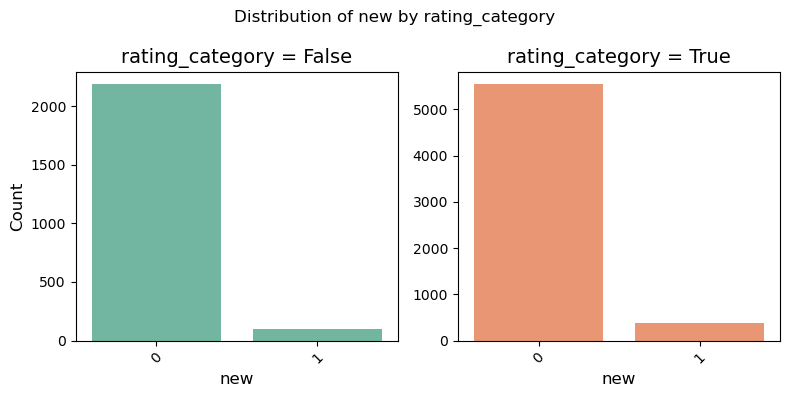

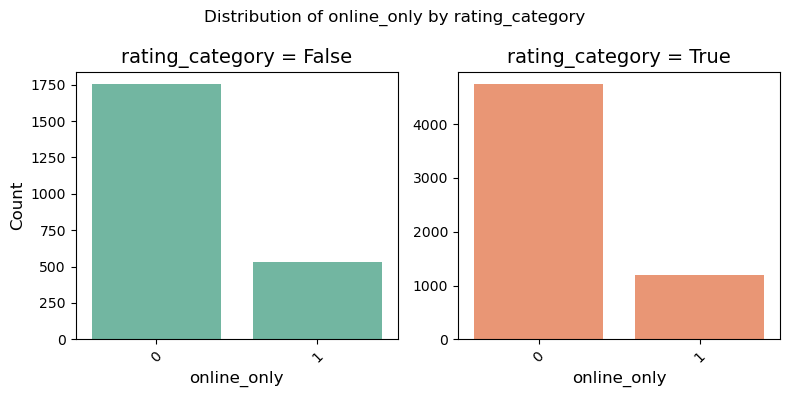

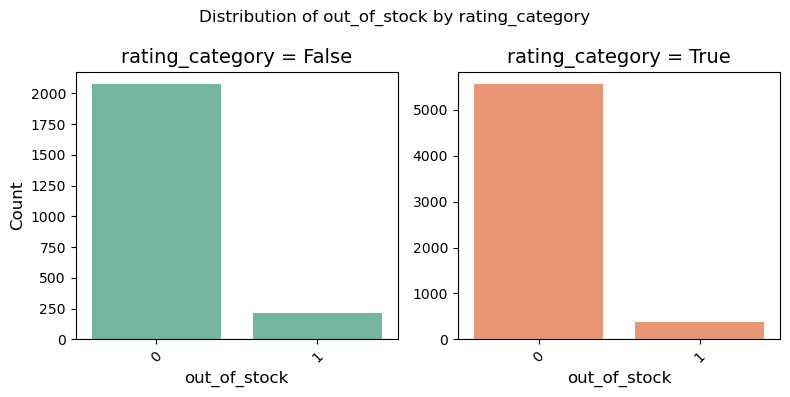

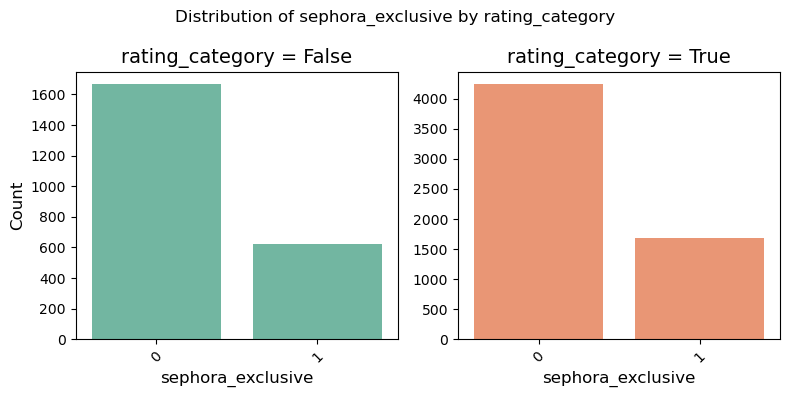

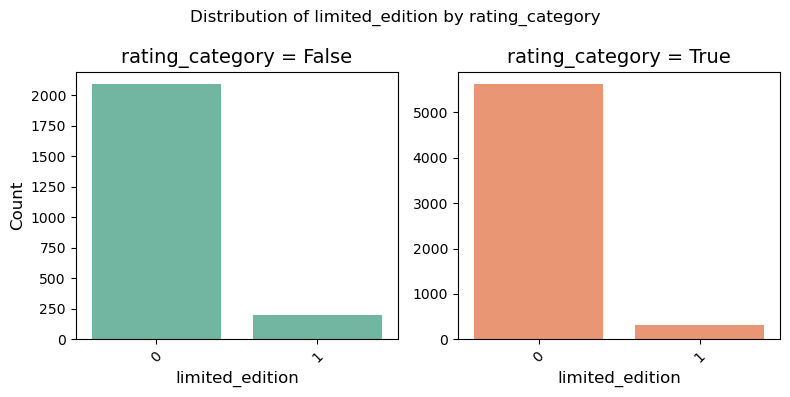

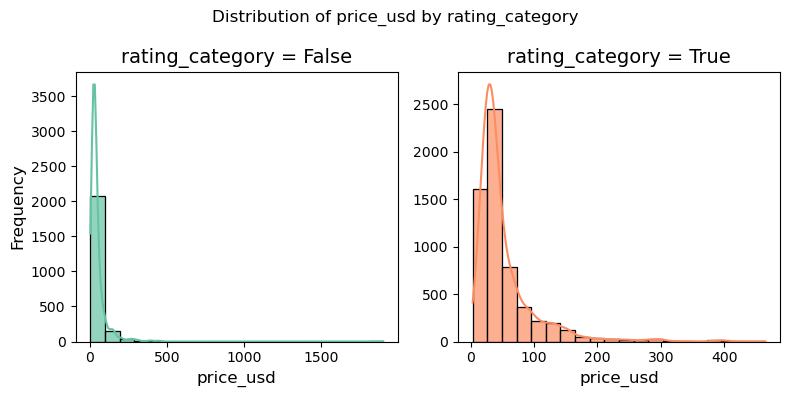

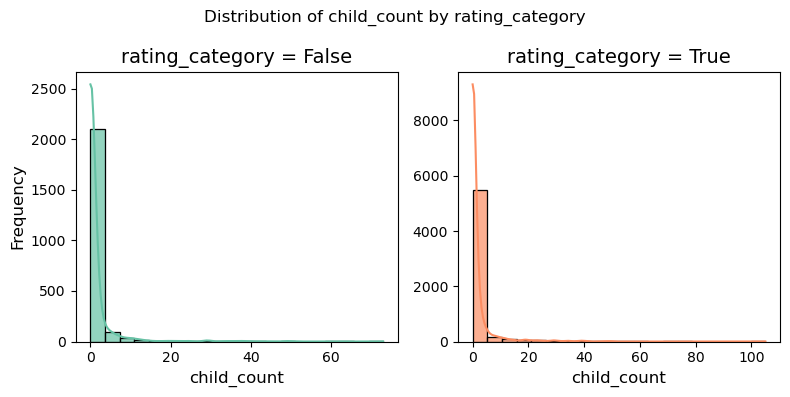

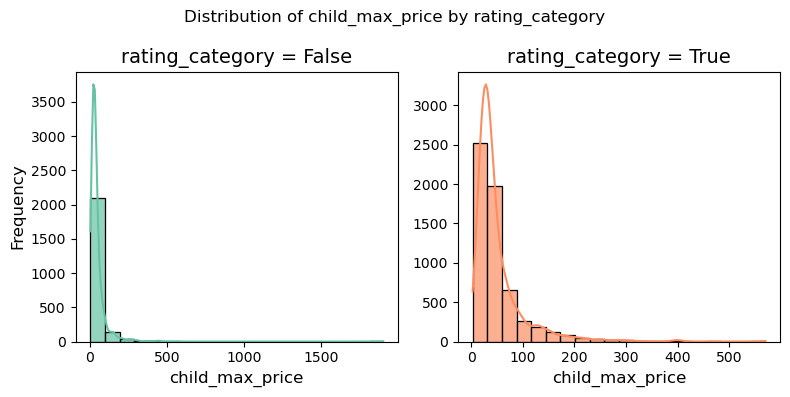

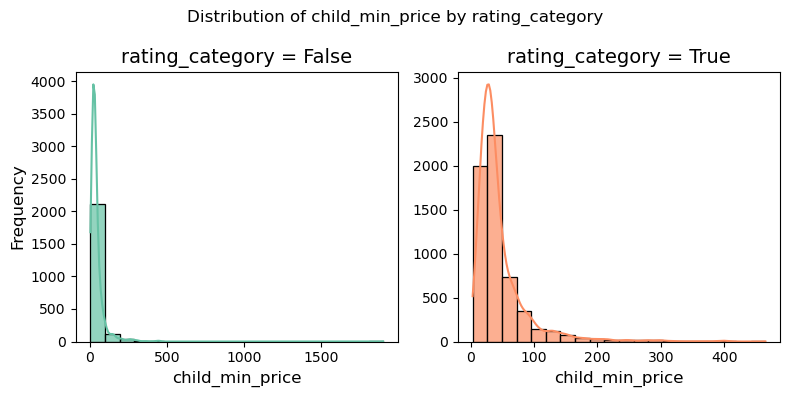

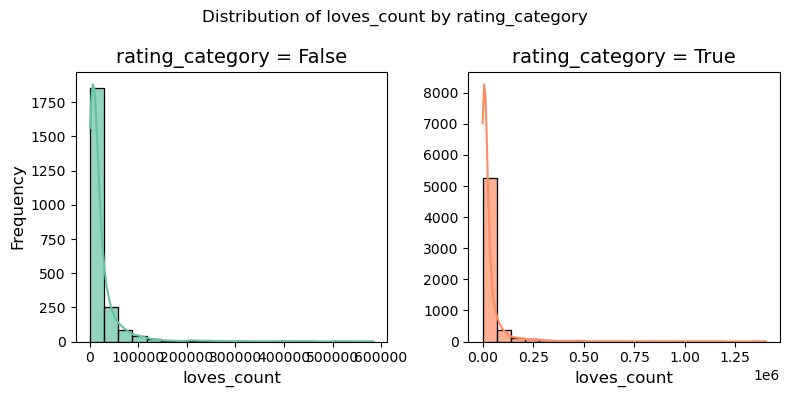

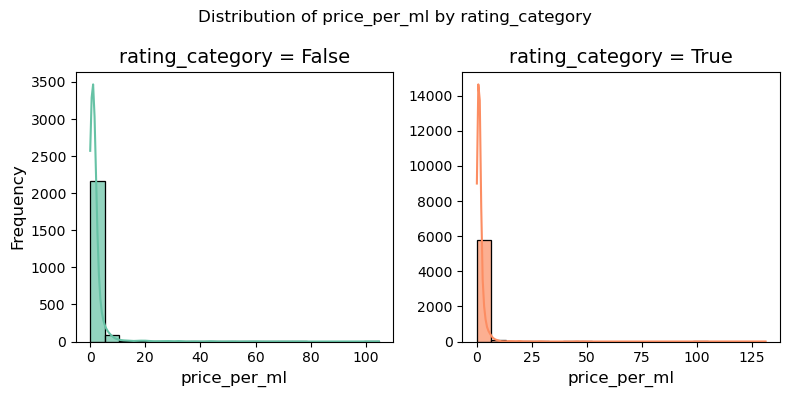

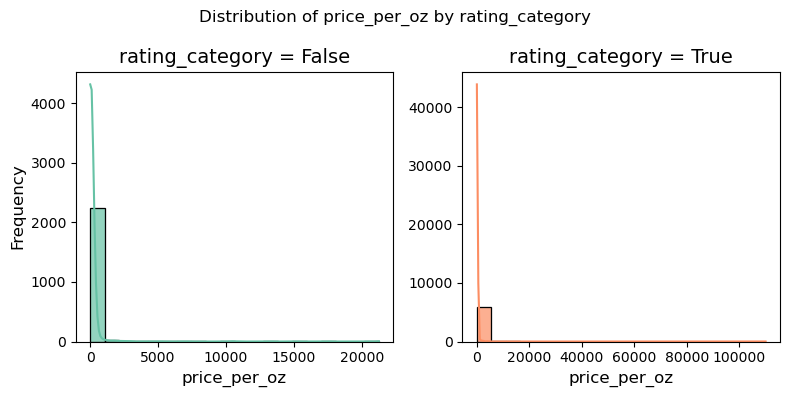

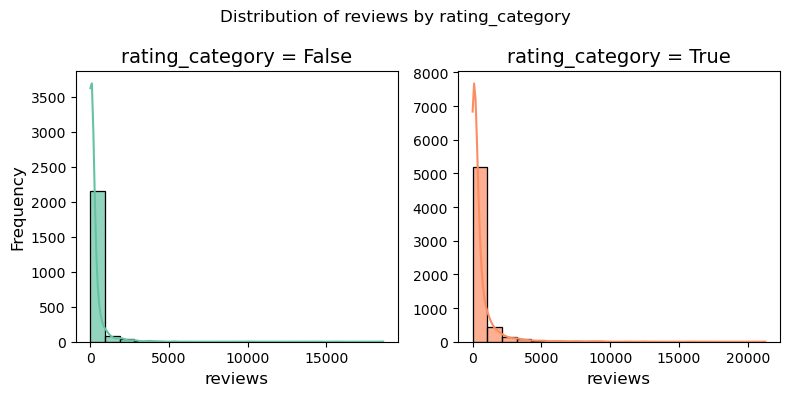

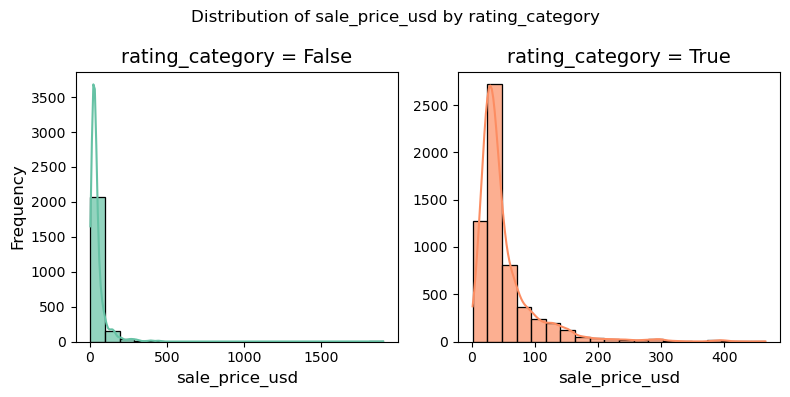

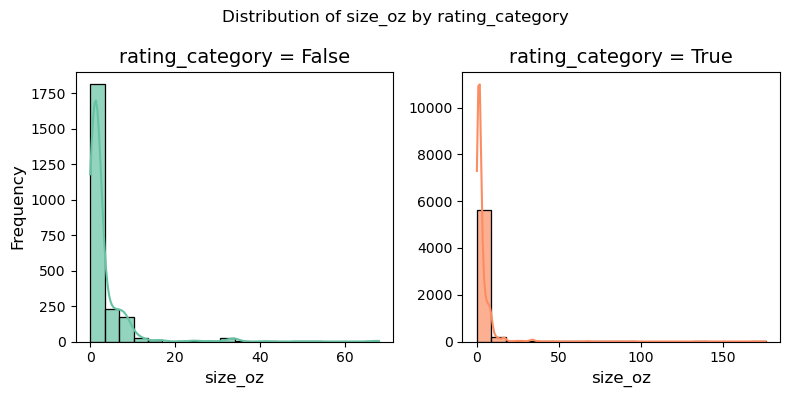

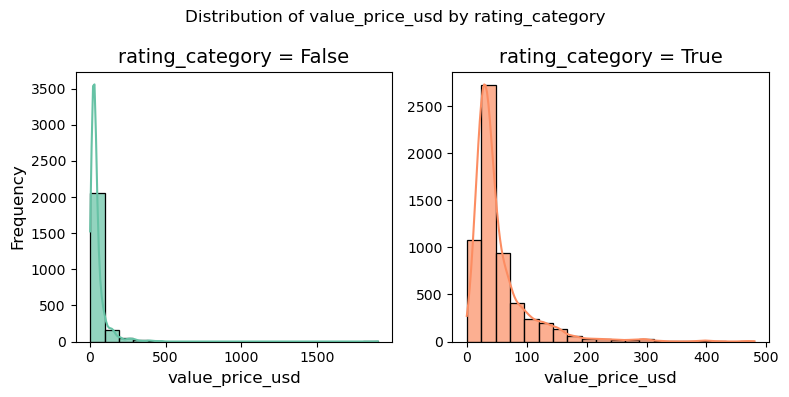

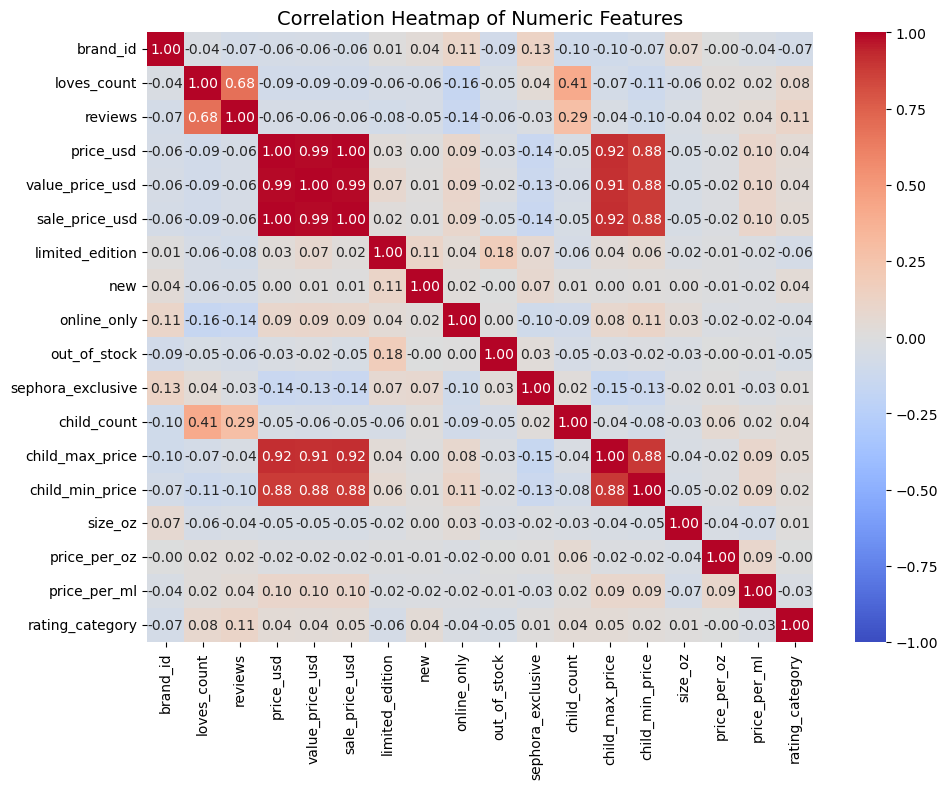

In [209]:
visualize_sephora_data_by_target(product_df, categorical_features, numerical_features, target="rating_category")

### Data Transformation

#### Numerical Features - Log Transformation

In [210]:
# Apply Log Transformation to several numeric features and visualize the changes
# Use ChatGPT to facilitate data transformation

def apply_log_transformation(df, features):
    """
    Apply log transformation to specified numeric features in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame.
    features (list): List of column names to log transform.
    
    Returns:
    pd.DataFrame: DataFrame with log-transformed features.
    """
    df_transformed = df.copy()
    for feature in features:
        if feature in df_transformed.columns:
            # Apply log1p to handle zeros
            df_transformed[feature] = np.log1p(df_transformed[feature])
        else:
            print(f"Feature '{feature}' not found in DataFrame.")
    return df_transformed

def apply_sqrt_transformation(df, features):
    """
    Apply square root transformation to specified numeric features in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame.
    features (list): List of column names to apply square root transformation.
    
    Returns:
    pd.DataFrame: DataFrame with square root-transformed features.
    """
    df_transformed = df.copy()
    for feature in features:
        if feature in df_transformed.columns:
            # Apply sqrt transformation, ensure non-negative values
            df_transformed[feature] = np.sqrt(df_transformed[feature].clip(lower=0))
        else:
            print(f"Feature '{feature}' not found in DataFrame.")
    return df_transformed


def visualize_features(df, features, bins=20):
    """
    Visualize the distributions of specified features in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame.
    features (list): List of column names to visualize.
    bins (int): Number of bins for the histograms.
    
    Returns:
    None
    """
    print("Visualizing features...")
    print(features + ["rating_category"])
    visualize_sephora_data_by_target(df[features + ["rating_category"]], categorical_features=[], \
        numerical_features=features, target="rating_category")

Log Transformed Features:
Visualizing features...
['child_max_price', 'child_min_price', 'reviews', 'loves_count', 'price_usd', 'price_per_ml', 'price_per_oz', 'sale_price_usd', 'value_price_usd', 'rating_category']


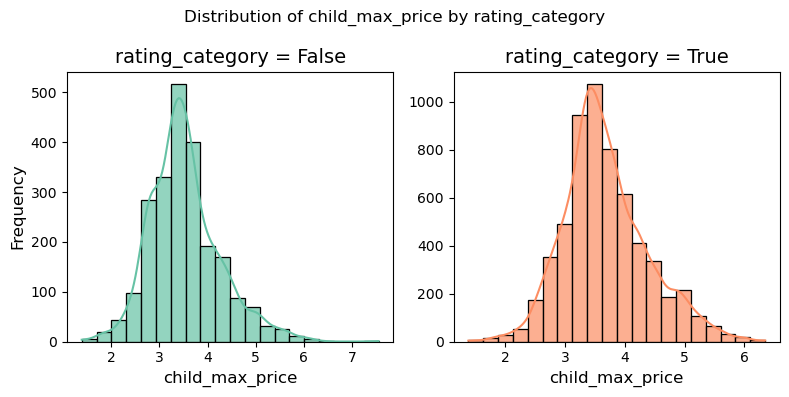

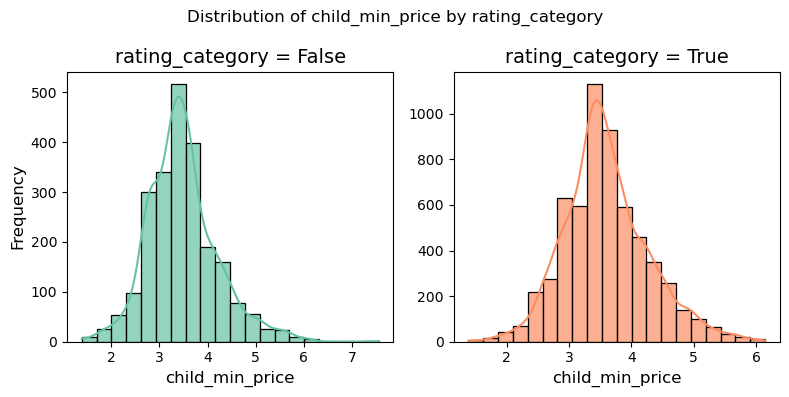

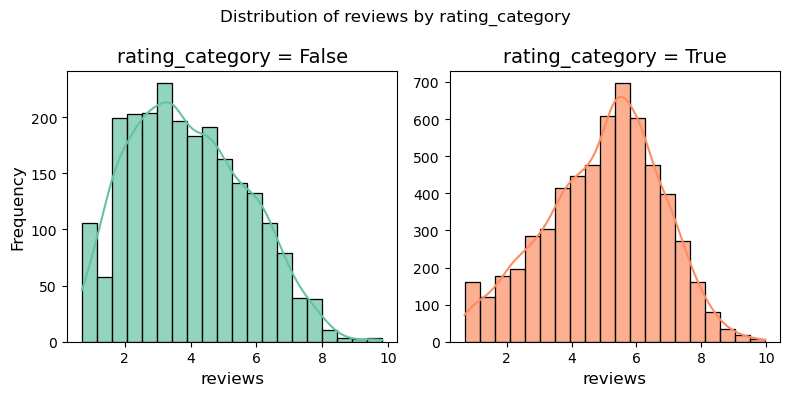

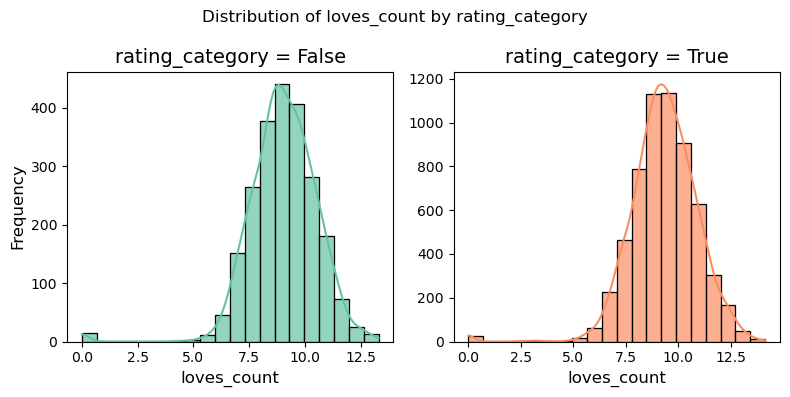

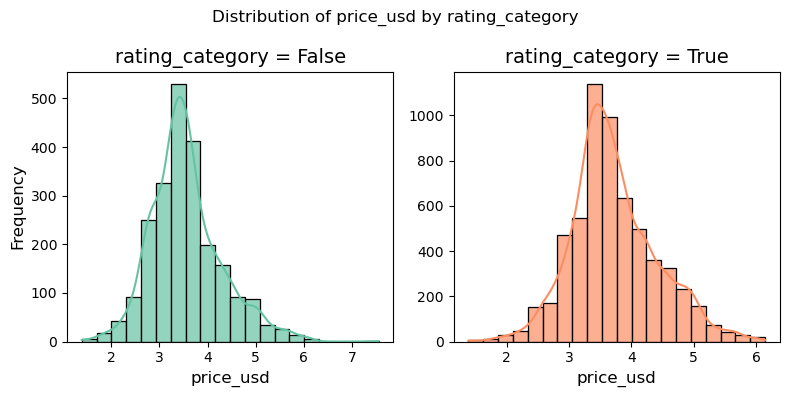

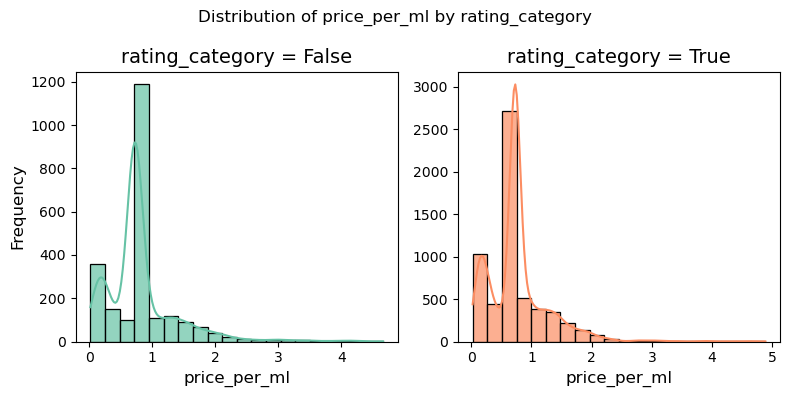

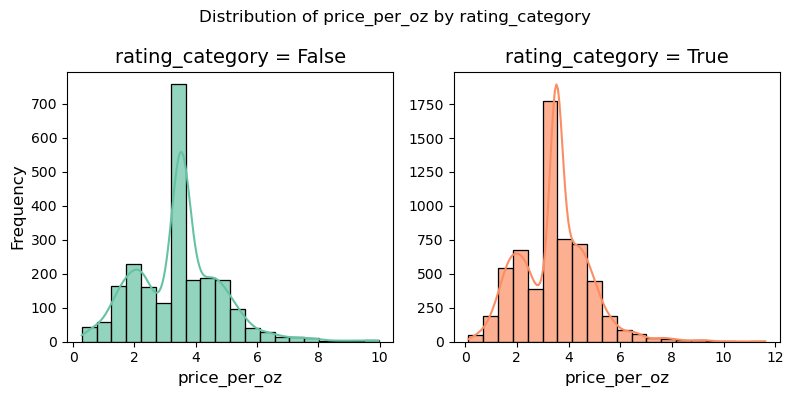

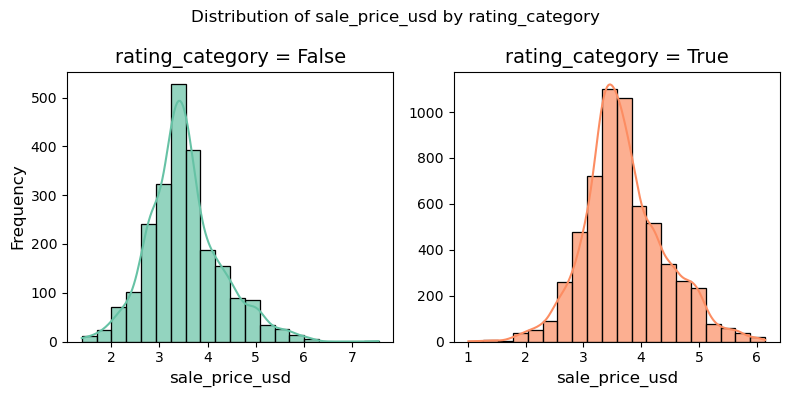

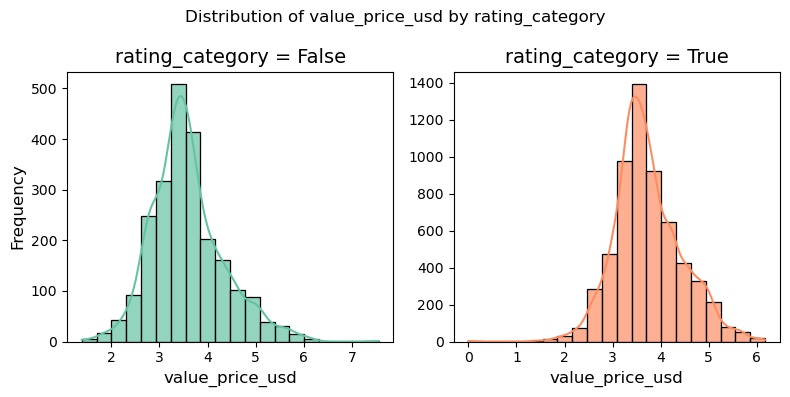

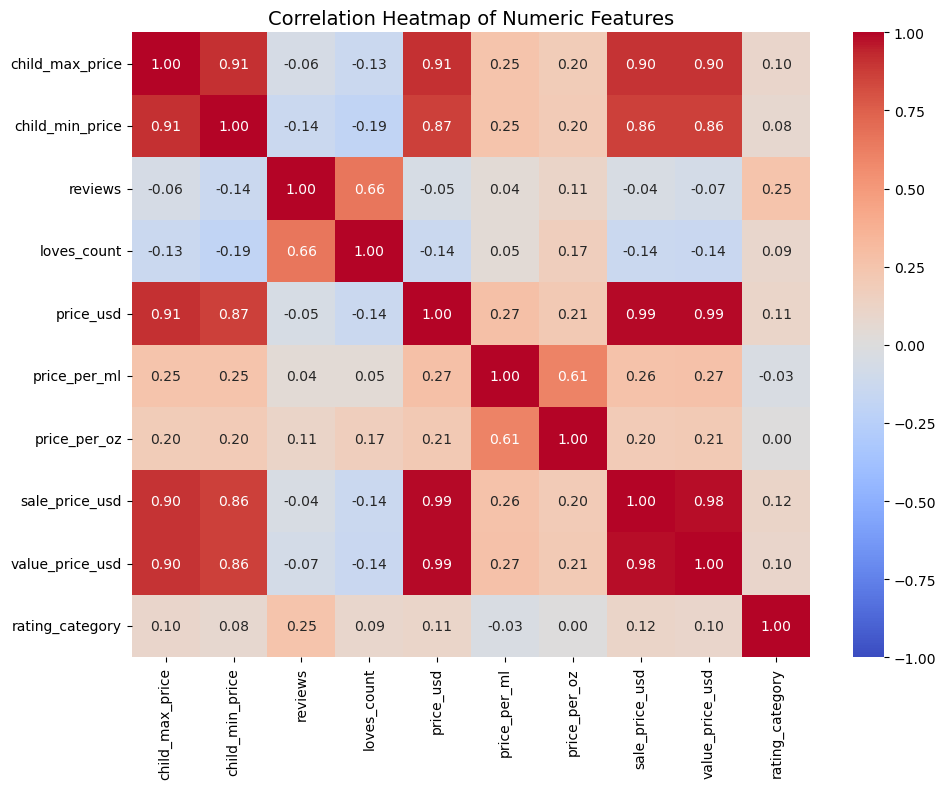

In [211]:
# Apply log transformation

features_to_transform = ['child_max_price', 'child_min_price', 
                    'reviews', 'loves_count', 'price_usd', 'price_per_ml',
                    'price_per_oz', 'sale_price_usd', 'value_price_usd']

product_df = apply_log_transformation(product_df, features_to_transform)

# Visualize transformed features
print("Log Transformed Features:")
visualize_features(product_df, features_to_transform)

#### Text Features - TF-IDF Encoding

In [214]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd

def tfidf_svd_transform(df, text_cols, n_components=50, max_features=500):
    """
    Apply TF-IDF vectorization and SVD, and append the reduced features to the original DataFrame.

    Parameters:
    df : pd.DataFrame
        Input DataFrame with text columns.
    text_cols : list
        List of column names to process.
    n_components : int
        Number of components for SVD dimensionality reduction.
    max_features : int
        Maximum number of features for TF-IDF vectorizer.

    Returns:
    pd.DataFrame
        DataFrame with the original data and added SVD components as new columns.
    """
    # Validate text columns
    missing_cols = [col for col in text_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are missing in the DataFrame: {missing_cols}")

    # Combine all specified text columns into a single column
    df['combined_text'] = df[text_cols].fillna('').astype(str).agg(' '.join, axis=1)
    
    # Check if combined_text is empty
    if df['combined_text'].str.strip().eq('').all():
        raise ValueError("All combined_text entries are empty. Check your input data.")

    # Apply TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(df['combined_text'])
    
    # Apply SVD for dimensionality reduction
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)
    
    # Create new DataFrame for SVD features
    svd_cols = [f'svd_feature_{i+1}' for i in range(n_components)]
    svd_df = pd.DataFrame(reduced_matrix, columns=svd_cols, index=df.index)
    
    # Add SVD features to the original DataFrame
    df = pd.concat([df, svd_df], axis=1)
    
    # Drop the combined text column to clean up
    df.drop(columns=['combined_text'], inplace=True)
    
    return df

In [215]:
# Define the text columns and validate the DataFrame
text_cols = ['product_name', 'variation_desc', 'variation_type', 'variation_value',
             'highlights', 'secondary_category', 'tertiary_category', 'ingredients',
             'brand_name']

# Ensure product_df exists and test the function
try:
    product_df = tfidf_svd_transform(product_df, text_cols, n_components=50, max_features=500)
    print(product_df.shape)
    display(product_df.head())
except Exception as e:
    print(f"Error: {e}")

(8216, 79)


,product_id,product_name,brand_id,brand_name,loves_count,reviews,variation_type,variation_value,variation_desc,ingredients,...,svd_feature_41,svd_feature_42,svd_feature_43,svd_feature_44,svd_feature_45,svd_feature_46,svd_feature_47,svd_feature_48,svd_feature_49,svd_feature_50
0,P473671,Fragrance Discovery Set,6342,19-69,8.751633,2.484907,Unknown,Unknown,No variation,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",...,-0.078107,-0.111825,0.065459,-0.004931,-0.024866,0.010552,-0.055882,0.022548,-0.042553,0.082854
1,P473668,La Habana Eau de Parfum,6342,19-69,8.250098,2.639057,Size + Concentration + Formulation,3.4 oz/ 100 mL,No variation,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",...,-0.058013,0.004859,-0.035321,0.036063,0.024997,0.058837,-0.083002,-0.002889,0.011897,0.017640
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,8.087640,2.833213,Size + Concentration + Formulation,3.4 oz/ 100 mL,No variation,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",...,-0.081061,-0.038222,-0.057624,0.017186,0.079040,0.030036,-0.074196,0.035998,-0.002999,0.078784
3,P473660,Kasbah Eau de Parfum,6342,19-69,8.012681,3.091042,Size + Concentration + Formulation,3.4 oz/ 100 mL,No variation,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",...,-0.079502,-0.051366,-0.057475,0.014495,0.082156,0.042790,-0.076759,0.028056,0.001309,0.078641
4,P473658,Purple Haze Eau de Parfum,6342,19-69,7.898040,2.639057,Size + Concentration + Formulation,3.4 oz/ 100 mL,No variation,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",...,-0.074152,-0.069375,-0.039888,0.034529,0.091316,0.048502,-0.062758,0.001462,-0.000939,0.063429


## Classification Analysis

### Train, tune, and ensemble machine learning models

Build multiple machine learning models, optimize their performance through hyperparameter tuning, and explore ensembling techniques to improve overall prediction accuracy.

In [216]:
# Step 1: Data Preprocessing
# Code generation by ChatGPT

from sklearn.model_selection import train_test_split

product_df = product_df.drop(columns=text_cols)

features = product_df.drop(columns=['rating_category', 'product_id', 'primary_category'])  # Feature data
target = product_df['rating_category']  # Target data

# Use train_test_split to split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target, 
    test_size=0.2, 
    random_state=42,
    stratify=target
)

# Print the shapes of the split datasets
print("Shape of training feature set:", X_train.shape)
print("Shape of test feature set:", X_test.shape)
print("Shape of training target set:", y_train.shape)
print("Shape of test target set:", y_test.shape)

Shape of training feature set: (6572, 67)
Shape of test feature set: (1644, 67)
Shape of training target set: (6572,)
Shape of test target set: (1644,)


In [217]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

y_train = y_train.astype(int)  # Convert target to integer (binary classification)
y_test = y_test.astype(int)  # Convert target to integer (binary classification)

# Define numerical and categorical features
categorical_features = ['new', 'online_only', 'out_of_stock', 'sephora_exclusive',
                        'limited_edition']
num_features = [col for col in X_train.columns if col not in categorical_features]

# Ensure all specified features exist in X_train
missing_categorical = [col for col in categorical_features if col not in X_train.columns]
if missing_categorical:
    raise ValueError(f"Categorical features missing in X_train: {missing_categorical}")

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), num_features),  # Apply scaling to numerical features
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Apply the preprocessing pipeline to X_train and X_test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Debug outputs to confirm transformation
print(f"Transformed X_train shape: {X_train_transformed.shape}")
print(f"Transformed X_test shape: {X_test_transformed.shape}")

Transformed X_train shape: (6572, 72)
Transformed X_test shape: (1644, 72)


In [218]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

# Step 2: Model Pipelines
# Define individual models
svm_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
                        probability=True, 
                        kernel="rbf",  # Radial Basis Function kernel
                        C=5,         # Regularization parameter
                        gamma="auto", # Kernel coefficient
                        random_state=42
                    ))
])

random_forest_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
            n_estimators=200,       # Number of trees
            max_depth=None,           # Maximum tree depth
            min_samples_split=4,    # Minimum number of samples required to split
            min_samples_leaf=2,     # Minimum number of samples in a leaf node
            max_features="sqrt",    # Number of features to consider at each split
            bootstrap=True,         # Use bootstrap samples
            random_state=42
    ))
])

gradient_boosting_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(
            n_estimators=150,       # Number of boosting stages
            learning_rate=0.1,     # Learning rate shrinks contribution of each tree
            max_depth=3,            # Maximum depth of the individual regression estimators
            min_samples_split=5,    # Minimum number of samples required to split
            min_samples_leaf=2,     # Minimum number of samples in a leaf node
            subsample=0.8,          # Fraction of samples to be used for fitting the individual base learners
            random_state=42
    ))
])

xgboost_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=200,       # Number of boosting rounds
        learning_rate=0.1,      # Shrinkage rate
        max_depth=3,            # Maximum depth of a tree
        subsample=0.8,          # Subsample ratio of training instances
        gamma=0.2,                # Minimum loss reduction for a split
        random_state=42
    ))
])

knn_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(
        n_neighbors=15,         # Number of neighbors
        weights="distance",     # Weight function (uniform or distance)
        algorithm="auto"       # Algorithm for nearest neighbors search
    ))
])

# Ensemble model (Voting Classifier)
ensemble_model = VotingClassifier(
    estimators=[
        ("svm", svm_model),
        ("rf", random_forest_model),
        ("gb", gradient_boosting_model),
        ("xgb", xgboost_model),
    ],
    voting="soft",  # Soft voting for probabilities,
    weights=[0.2, 0.2, 0.3, 0.3]  # Weights for voting
)

# Step 3: Cross-validation with multiple metrics in one pass
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Support Vector Machine": svm_model,
    "Random Forest": random_forest_model,
    "Gradient Boosting": gradient_boosting_model,
    "XGBoost": xgboost_model,
    "Ensemble": ensemble_model
}

# Define multiple scoring metrics
scoring_metrics = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average="binary"),
    "recall": make_scorer(recall_score, average="binary"),
    "f1": make_scorer(f1_score, average="binary"),
    "roc_auc": "roc_auc",
}

cv_results = {}

# Evaluate each model with cross_validate
for model_name, model in models.items():
    results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring_metrics)
    cv_results[model_name] = {metric: np.mean(results[f'test_{metric}']) for metric in scoring_metrics.keys()}

# Display cross-validation results
print("Cross-Validation Results (by Model):")
for model_name, metrics in cv_results.items():
    print(f"\nModel: {model_name}")
    for metric_name, score in metrics.items():
        print(f"  {metric_name}: {score:.4f}")

Cross-Validation Results (by Model):

Model: Support Vector Machine
  accuracy: 0.7296
  precision: 0.7842
  recall: 0.8631
  f1: 0.8216
  roc_auc: 0.7298

Model: Random Forest
  accuracy: 0.7381
  precision: 0.7501
  recall: 0.9557
  f1: 0.8404
  roc_auc: 0.7461

Model: Gradient Boosting
  accuracy: 0.7406
  precision: 0.7668
  recall: 0.9202
  f1: 0.8365
  roc_auc: 0.7567

Model: XGBoost
  accuracy: 0.7427
  precision: 0.7711
  recall: 0.9152
  f1: 0.8369
  roc_auc: 0.7610

Model: Ensemble
  accuracy: 0.7453
  precision: 0.7622
  recall: 0.9406
  f1: 0.8420
  roc_auc: 0.7700


In [220]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Step 4: Fit the ensemble model and predict
ensemble_model.fit(X_train, y_train)
predictions = ensemble_model.predict(X_test)
predicted_probabilities = ensemble_model.predict_proba(X_test)  # For metrics requiring probabilities

# Step 5: Evaluate the ensemble model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predicted_probabilities[:, 1])  # Use the positive class probabilities
logloss = log_loss(y_test, predicted_probabilities)

# Display the evaluation results
print("Ensemble Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

Ensemble Model Evaluation:
Accuracy: 0.7457
Precision: 0.7619
Recall: 0.9418
F1 Score: 0.8424
ROC-AUC: 0.7652
Log Loss: 0.5041


### Cross-Validation

In [222]:
# Code generation by ChatGPT
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define hyperparameter grids for each model
param_grids = {
    "Support Vector Machine": {
        "classifier__C": [0.5, 1, 4, 5, 6, 8, 10],  # Regularization parameter
        "classifier__gamma": ["scale", "auto"],  # Kernel coefficient
        "classifier__kernel": ["rbf", "linear"]  # Kernel type
    },
    "Random Forest": {
        "classifier__n_estimators": [50, 100, 150, 200],
        "classifier__max_depth": [10, 15, 20, None],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4]
    },
    "Gradient Boosting": {
        "classifier__n_estimators": [100, 150, 200],
        "classifier__learning_rate": [0.01, 0.05, 0.1, 0.3],
        "classifier__max_depth": [3, 5, 8, 10]
    },
    "XGBoost": {
        "classifier__n_estimators": [100, 150, 200],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__max_depth": [3, 5, 8, 10], 
        "classifier__gamma": [0, 0.1, 0.2, 0.5]
    },
    "Ensemble": {
        "weights": [[0.2, 0.2, 0.3, 0.3], [0.25, 0.25, 0.25, 0.25], \
            [0.2, 0.3, 0.2, 0.3]]# Weights for voting
        },
}

# Function to perform hyperparameter tuning
def hyperparameter_optimization(models, param_grids, X, y):
    optimized_models = {}
    for model_name, model in models.items():
        print(f"\nOptimizing {model_name}...")
        param_grid = param_grids.get(model_name, {})
        search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="roc_auc",  # Use AUC-ROC as the optimization metric
            cv=5,              # 5-fold cross-validation
            verbose=1,
            n_jobs=-1          # Use all available cores
        )
        search.fit(X, y)
        optimized_models[model_name] = search.best_estimator_
        print(f"Best parameters for {model_name}: {search.best_params_}")
        print(f"Best ROC-AUC for {model_name}: {search.best_score_:.4f}")
    return optimized_models

# Perform hyperparameter tuning
optimized_models = hyperparameter_optimization(models, param_grids, X_train, y_train)


Optimizing Support Vector Machine...
Fitting 5 folds for each of 28 candidates, totalling 140 fits


KeyboardInterrupt: 